Nguyen Ngoc Tieu Long

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import preprocessing
import sklearn.metrics as metrics

# START: DATA GATHERING

In [93]:
# Các thuộc tính của dataset
col_names = ["duration", "protocol_type", "service", "flag", "src_bytes",
             "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
             "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
             "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
             "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
             "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
             "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
             "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
             "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
             "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

In [94]:
# Load dataset
origin_train_dataFrame = pd.read_csv("NSL_KDD_Train.csv", header=None, names=col_names)
origin_test_dataFrame = pd.read_csv("NSL_KDD_Test.csv", header=None, names=col_names)
# origin_train_dataFrame.drop("score",axis=1,inplace=True)
# origin_test_dataFrame.drop("score",axis=1,inplace=True)
print(origin_train_dataFrame.shape)
print(origin_test_dataFrame.shape)

(125973, 42)
(22544, 42)


Nhóm các features vào 3 nhóm

In [95]:
# nominal features: 2 - 3 - 4
# binary features: 7 - 12 - 14 - 15 - 21
# Còn lại là numeric features
nominal_features = ["protocol_type", "service", "flag"]
binary_features = ["land", "logged_in", "root_shell",
                   "su_attempted", "is_host_login", "is_guest_login"]
numeric_features = []
for feature in col_names:
    if ((feature not in nominal_features) and (feature not in binary_features) and (feature != "label")):
        numeric_features.append(feature)

In [96]:
# Liệt kê các features theo từng nhóm
print("Nominal feature (", len(nominal_features), "): ", nominal_features, sep="")
print("Binary features (", len(binary_features), "): ", binary_features, sep="")
print("Numeric features (", len(numeric_features), "): ", numeric_features, sep="")

Nominal feature (3): ['protocol_type', 'service', 'flag']
Binary features (6): ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']
Numeric features (32): ['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'num_compromised', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


Chia lại các record vào 4 phân lớp tấn công

In [97]:
# Xem sự phân phối các subclass
print(origin_train_dataFrame["label"].unique())
print(origin_test_dataFrame["label"].unique())

trainLabels = origin_train_dataFrame["label"].tolist()
testLabels = origin_test_dataFrame["label"].tolist()

differentLabels = list(set(testLabels) - set(trainLabels))
print(differentLabels)
# N19DCAT033 - Tran Viet Hoang

['normal' 'neptune' 'warezclient' 'ipsweep' 'portsweep' 'teardrop' 'nmap'
 'satan' 'smurf' 'pod' 'back' 'guess_passwd' 'ftp_write' 'multihop'
 'rootkit' 'buffer_overflow' 'imap' 'warezmaster' 'phf' 'land'
 'loadmodule' 'spy' 'perl']
['neptune' 'normal' 'saint' 'mscan' 'guess_passwd' 'smurf' 'apache2'
 'satan' 'buffer_overflow' 'back' 'warezmaster' 'snmpgetattack'
 'processtable' 'pod' 'httptunnel' 'nmap' 'ps' 'snmpguess' 'ipsweep'
 'mailbomb' 'portsweep' 'multihop' 'named' 'sendmail' 'loadmodule' 'xterm'
 'worm' 'teardrop' 'rootkit' 'xlock' 'perl' 'land' 'xsnoop' 'sqlattack'
 'ftp_write' 'imap' 'udpstorm' 'phf']
['snmpguess', 'named', 'mailbomb', 'xterm', 'sqlattack', 'xsnoop', 'processtable', 'xlock', 'snmpgetattack', 'saint', 'mscan', 'apache2', 'udpstorm', 'sendmail', 'worm', 'ps', 'httptunnel']


In [98]:
# Trước tiên cần phải liệt kê danh sách các subclass của 4 phân lớp DoS, Probe, U2R, R2L
# Tấn công DoS
label_DoS = ['apache2', 'back', 'land', 'neptune', 'mailbomb',
             'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm', 'worm']
# Tấn công thu thập thông tin
label_Probe = ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']
# Tấn công chiếm quyền, leo thang đặc quyền
label_U2R = ['buffer_overflow', 'loadmodule',
             'perl', 'ps', 'rootkit', 'sqlattack', 'xterm']
# Tấn công kết nối truy cập từ xa
label_R2L = ['ftp_write', 'guess_passwd', 'httptunnel', 'imap', 'multihop', 'named', 'phf',
             'sendmail', 'snmpgetattack', 'snmpguess', 'spy', 'warezclient', 'warezmaster', 'xlock', 'xsnoop']

Tách column label thành labels2 (normal - attack) và labels5 (normal - DoS, Probe, R2L, U2R)

In [99]:
attack_labels = []
attack_labels.extend(label_DoS)
attack_labels.extend(label_Probe)
attack_labels.extend(label_U2R)
attack_labels.extend(label_R2L)

In [100]:
# Đối với TRAIN DATASET
origin_train_dataFrame.rename(columns={"label": "labels2"}, inplace=True)
trainLabels2Column = origin_train_dataFrame["labels2"].tolist()
origin_train_dataFrame["labels5"] = trainLabels2Column
origin_train_dataFrame["labels2"].replace(attack_labels, "attack", inplace=True)


In [101]:
# Đối với TEST DATASET
origin_test_dataFrame.rename(columns={"label": "labels2"}, inplace=True)
testLabels2Column = origin_test_dataFrame["labels2"].tolist()
origin_test_dataFrame["labels5"] = testLabels2Column
origin_test_dataFrame["labels2"].replace(attack_labels, "attack", inplace=True)

In [102]:
print(origin_train_dataFrame["labels2"].unique())
print(origin_train_dataFrame["labels5"].unique())
print()
print(origin_test_dataFrame["labels2"].unique())
print(origin_test_dataFrame["labels5"].unique())

['normal' 'attack']
['normal' 'neptune' 'warezclient' 'ipsweep' 'portsweep' 'teardrop' 'nmap'
 'satan' 'smurf' 'pod' 'back' 'guess_passwd' 'ftp_write' 'multihop'
 'rootkit' 'buffer_overflow' 'imap' 'warezmaster' 'phf' 'land'
 'loadmodule' 'spy' 'perl']

['attack' 'normal']
['neptune' 'normal' 'saint' 'mscan' 'guess_passwd' 'smurf' 'apache2'
 'satan' 'buffer_overflow' 'back' 'warezmaster' 'snmpgetattack'
 'processtable' 'pod' 'httptunnel' 'nmap' 'ps' 'snmpguess' 'ipsweep'
 'mailbomb' 'portsweep' 'multihop' 'named' 'sendmail' 'loadmodule' 'xterm'
 'worm' 'teardrop' 'rootkit' 'xlock' 'perl' 'land' 'xsnoop' 'sqlattack'
 'ftp_write' 'imap' 'udpstorm' 'phf']


In [103]:
# Đối với TRAIN DATASET
# Chia các record vào DoS
origin_train_dataFrame["labels5"].replace(label_DoS, "DoS", inplace=True)
# Chia các record vào Probe
origin_train_dataFrame["labels5"].replace(label_Probe, "Probe", inplace=True)
# Chia các record vào U2R
origin_train_dataFrame["labels5"].replace(label_U2R, "U2R", inplace=True)
# Chia các record vào R2L
origin_train_dataFrame["labels5"].replace(label_R2L, "R2L", inplace=True)

# Đối với TEST DATASET
# Chia các record vào DoS
origin_test_dataFrame["labels5"].replace(label_DoS, "DoS", inplace=True)
# Chia các record vào Probe
origin_test_dataFrame["labels5"].replace(label_Probe, "Probe", inplace=True)
# Chia các record vào U2R
origin_test_dataFrame["labels5"].replace(label_U2R, "U2R", inplace=True)
# Chia các record vào R2L
origin_test_dataFrame["labels5"].replace(label_R2L, "R2L", inplace=True)

normal    67343
attack    58630
Name: labels2, dtype: int64


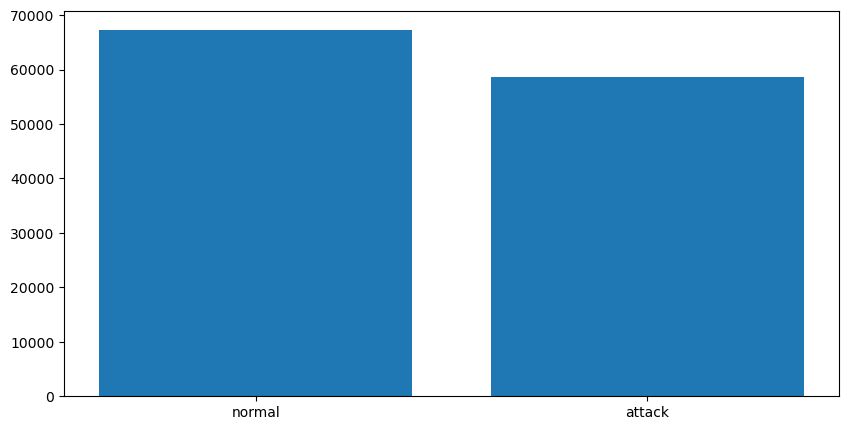

In [104]:
# Xem sự phân phối theo normal - attack
print(origin_train_dataFrame["labels2"].value_counts())
# Vẽ biểu đồ phân phối theo normal - attack
x_label_distribute = np.array(
    origin_train_dataFrame["labels2"].value_counts().index.tolist())
y_label_distribute = np.array(
    origin_train_dataFrame["labels2"].value_counts().values.tolist())
plt.bar(x_label_distribute, y_label_distribute)
plt.show()

normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: labels5, dtype: int64


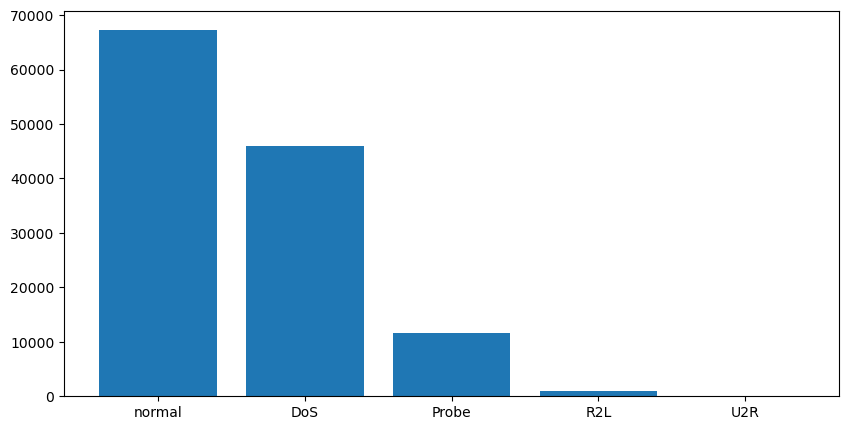

In [105]:
# Xem lại sự phân phối theo lớp tấn công
print(origin_train_dataFrame["labels5"].value_counts())
# Vẽ biểu đồ phân phối theo lớp tấn công
x_label_distribute = np.array(
    origin_train_dataFrame["labels5"].value_counts().index.tolist())
y_label_distribute = np.array(
    origin_train_dataFrame["labels5"].value_counts().values.tolist())
plt.bar(x_label_distribute, y_label_distribute)
plt.show()

# END: DATA GATHERING

# START: DATA PROCESSING

In [106]:
# N19DCAT033 - Tran Viet Hoang
# Trong dataset nsl-kdd có 3 thuộc tính nominal (string) nên không thể thực hiện tính toán các chỉ số trực tiếp
# Sử dụng one-hot encoding để chuyển các nominal attribute sang numeric attribute
# Các feature được scale để tránh việc các feature mang giá trị quá lớn ảnh hưởng tới kết quả của mô hình

In [107]:
# Số lượng các giá trị khác nhau trong 3 nominal attribute
print("\nNumber of unique values in TRAIN DATASET for nominal attributes")
for col in origin_train_dataFrame.columns:
    if origin_train_dataFrame[col].dtypes == 'object':
        unique_cat = len(origin_train_dataFrame[col].unique())
        print("Feature '{col}' has {unique_cat} categories".format(
            col=col, unique_cat=unique_cat))

print("\nNumber of unique values in TEST DATASET for nominal attributes")
for col in origin_test_dataFrame.columns:
    if origin_test_dataFrame[col].dtypes == 'object':
        unique_cat = len(origin_test_dataFrame[col].unique())
        print("Feature '{col}' has {unique_cat} categories".format(
            col=col, unique_cat=unique_cat))


Number of unique values in TRAIN DATASET for nominal attributes
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'labels2' has 2 categories
Feature 'labels5' has 5 categories

Number of unique values in TEST DATASET for nominal attributes
Feature 'protocol_type' has 3 categories
Feature 'service' has 64 categories
Feature 'flag' has 11 categories
Feature 'labels2' has 2 categories
Feature 'labels5' has 5 categories


In [108]:
# Với TRAIN DATASET thì sẽ có tổng cộng 3+70+11=84 dummies khi sử dụng one-hot encoding
# Với TEST DATASET thì sẽ có tổng cộng 3+64+11=78 dummies khi sử dụng one-hot encoding

Đưa các nominal (categorical) feature vào mảng numpy 2D (2D numpy array)

In [109]:
train_dataset_categorical_values = origin_train_dataFrame[nominal_features]
test_dataset_categorical_values = origin_test_dataFrame[nominal_features]

print(train_dataset_categorical_values.head())

  protocol_type   service flag
0           tcp  ftp_data   SF
1           udp     other   SF
2           tcp   private   S0
3           tcp      http   SF
4           tcp      http   SF


THỰC HIỆN DUMMY CÁC COLUMN (ATTRIBUTE)

In [110]:
# protocol type
unique_protocol = sorted(origin_train_dataFrame.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2 = [string1 + x for x in unique_protocol]
# service
unique_service = sorted(origin_train_dataFrame.service.unique())
string2 = 'service_'
unique_service2 = [string2 + x for x in unique_service]
# flag
unique_flag = sorted(origin_train_dataFrame.flag.unique())
string3 = 'flag_'
unique_flag2 = [string3 + x for x in unique_flag]
# Put together
dumcols = unique_protocol2 + unique_service2 + unique_flag2
print(dumcols)

['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'serv

In [111]:
# Tương tự với TEST DATASET nhưng ở service chỉ có 64 giá trị khác nhau
unique_service_test = sorted(origin_test_dataFrame.service.unique())
unique_service2_test = [string2 + x for x in unique_service_test]
testdumcols = unique_protocol2 + unique_service2_test + unique_flag2

Chuyển categorical feature sang numerical sử dụng LabelEncoder()

In [112]:
dataset_train_categorical_values_enc = train_dataset_categorical_values.apply(
    LabelEncoder().fit_transform)
# test set
dataset_test_categorical_values_enc = test_dataset_categorical_values.apply(
    LabelEncoder().fit_transform)
print(dataset_train_categorical_values_enc.head())

   protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9


ONE-HOT ENCODING

In [113]:
enc = OneHotEncoder()
# TRAIN DATASET
dataset_train_categorical_values_encenc = enc.fit_transform(
    dataset_train_categorical_values_enc)
dataset_train_cat_data = pd.DataFrame(
    dataset_train_categorical_values_encenc.toarray(), columns=dumcols)
# TEST DATASET
dataset_test_categorical_values_encenc = enc.fit_transform(
    dataset_test_categorical_values_enc)
dataset_test_cat_data = pd.DataFrame(
    dataset_test_categorical_values_encenc.toarray(), columns=testdumcols)

print(dataset_train_cat_data)

        Protocol_type_icmp  Protocol_type_tcp  Protocol_type_udp  service_IRC  \
0                      0.0                1.0                0.0          0.0   
1                      0.0                0.0                1.0          0.0   
2                      0.0                1.0                0.0          0.0   
3                      0.0                1.0                0.0          0.0   
4                      0.0                1.0                0.0          0.0   
...                    ...                ...                ...          ...   
125968                 0.0                1.0                0.0          0.0   
125969                 0.0                0.0                1.0          0.0   
125970                 0.0                1.0                0.0          0.0   
125971                 0.0                1.0                0.0          0.0   
125972                 0.0                1.0                0.0          0.0   

        service_X11  servic

Thêm 6 giá trị category trong attribute service từ TRAIN DATASET vào TEST DATASET

In [114]:
trainservice = origin_train_dataFrame['service'].tolist()
testservice = origin_test_dataFrame['service'].tolist()
difference = list(set(trainservice) - set(testservice))
string = 'service_'
difference = [string + x for x in difference]
print(difference)
for col in difference:
    dataset_test_cat_data[col] = 0

['service_urh_i', 'service_aol', 'service_harvest', 'service_http_2784', 'service_red_i', 'service_http_8001']


Join encoded categorical dataframe với các dataframe khác

In [115]:
newdf = origin_train_dataFrame.join(dataset_train_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)
# test data
newdf_test = origin_test_dataFrame.join(dataset_test_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)
# Shape sẽ thay đổi, tăng column
print(origin_train_dataFrame.shape)
print(origin_test_dataFrame.shape)
print(newdf.shape)
print(newdf_test.shape)

(125973, 43)
(22544, 43)
(125973, 124)
(22544, 124)


Đặt lại giá trị cho label 0=normal, 1=DoS, 2=Probe, 3=R2L and 4=U2R

In [116]:
# Lấy label column
labels5df = newdf['labels5']
labels5df_test = newdf_test['labels5']

labels2df = newdf['labels2']
labels2df_test = newdf_test['labels2']
# Đổi label column
newlabels5df = labels5df.replace(
    {'normal': 0, 'DoS': 1, 'Probe': 2, 'R2L': 3, 'U2R': 4})
newlabels5df_test = labels5df_test.replace(
    {'normal': 0, 'DoS': 1, 'Probe': 2, 'R2L': 3, 'U2R': 4})

newlabels2df = labels2df.replace({'normal': 0, 'attack': 1})
newlabels2df_test = labels2df_test.replace({'normal': 0, 'attack': 1})
# Đưa label mới vào
newdf['labels5'] = newlabels5df
newdf_test['labels5'] = newlabels5df_test

newdf['labels2'] = newlabels2df
newdf_test['labels2'] = newlabels2df_test

print(newdf['labels5'].value_counts())

0    67343
1    45927
2    11656
3      995
4       52
Name: labels5, dtype: int64


In [117]:
print(newdf["labels2"].value_counts())

0    67343
1    58630
Name: labels2, dtype: int64


Tạo dataframe cho từng kiểu tấn công

In [118]:
# 0 = normal, 1 = DoS, 2 = Probe, 3 = R2L, 4 = U2R
to_drop_DoS = [2, 3, 4]
to_drop_Probe = [1, 3, 4]
to_drop_R2L = [1, 2, 4]
to_drop_U2R = [1, 2, 3]
# Tạo dataframe cho từng loại tấn công dựa vào newdf với feature "label" không chứa các nhãn trong top_drop_typeOfAttack
DoS_df = newdf[~newdf['labels5'].isin(to_drop_DoS)]
Probe_df = newdf[~newdf['labels5'].isin(to_drop_Probe)]
R2L_df = newdf[~newdf['labels5'].isin(to_drop_R2L)]
U2R_df = newdf[~newdf['labels5'].isin(to_drop_U2R)]

# test
DoS_df_test = newdf_test[~newdf_test['labels5'].isin(to_drop_DoS)]
Probe_df_test = newdf_test[~newdf_test['labels5'].isin(to_drop_Probe)]
R2L_df_test = newdf_test[~newdf_test['labels5'].isin(to_drop_R2L)]
U2R_df_test = newdf_test[~newdf_test['labels5'].isin(to_drop_U2R)]

In [119]:
print('Train:')
print("Dimensions of train:", newdf.shape)
print('Dimensions of DoS:', DoS_df.shape)
print('Dimensions of Probe:', Probe_df.shape)
print('Dimensions of R2L:', R2L_df.shape)
print('Dimensions of U2R:', U2R_df.shape)
print('Test:')
print("Dimensions of test:", newdf_test.shape)
print('Dimensions of DoS:', DoS_df_test.shape)
print('Dimensions of Probe:', Probe_df_test.shape)
print('Dimensions of R2L:', R2L_df_test.shape)
print('Dimensions of U2R:', U2R_df_test.shape)


Train:
Dimensions of train: (125973, 124)
Dimensions of DoS: (113270, 124)
Dimensions of Probe: (78999, 124)
Dimensions of R2L: (68338, 124)
Dimensions of U2R: (67395, 124)
Test:
Dimensions of test: (22544, 124)
Dimensions of DoS: (17171, 124)
Dimensions of Probe: (12132, 124)
Dimensions of R2L: (12596, 124)
Dimensions of U2R: (9778, 124)


FEATURE SCALING

In [120]:
# Chia dataframe thành X & Y
# N19DCAT033 - Tran Viet Hoang
# Tạo multi_train_data để tránh làm biến đổi train dataset gốc khi scale dữ liệu
multi_train_data = origin_train_dataFrame.copy()
multi_test_data = origin_test_dataFrame.copy()
# Chia X là dataframe gồm các feature, Y là các nhãn tấn công (lớp tấn công)
X_train = newdf.drop(['labels2','labels5'], axis=1)
Y_train = newdf.labels5

X_DoS = DoS_df.drop(['labels2','labels5'], axis=1)
Y_DoS = DoS_df.labels5
X_Probe = Probe_df.drop(['labels2','labels5'], axis=1)
Y_Probe = Probe_df.labels5
X_R2L = R2L_df.drop(['labels2','labels5'], axis=1)
Y_R2L = R2L_df.labels5
X_U2R = U2R_df.drop(['labels2','labels5'], axis=1)
Y_U2R = U2R_df.labels5
# test set
X_test = newdf_test.drop(['labels2','labels5'], axis=1)
Y_test = newdf_test.labels5

X_DoS_test = DoS_df_test.drop(['labels2','labels5'], axis=1)
Y_DoS_test = DoS_df_test.labels5
X_Probe_test = Probe_df_test.drop(['labels2','labels5'], axis=1)
Y_Probe_test = Probe_df_test.labels5
X_R2L_test = R2L_df_test.drop(['labels2','labels5'], axis=1)
Y_R2L_test = R2L_df_test.labels5
X_U2R_test = U2R_df_test.drop(['labels2','labels5'], axis=1)
Y_U2R_test = U2R_df_test.labels5

colNames = list(X_DoS)
colNames_test = list(X_DoS_test)

Dùng StandardScaler() và MinMaxScaler() để scale dataframes

In [121]:
# Scale dữ liệu sẽ chuyển dữ liệu tỷ lệ hoặc định dạng dữ liệu về cùng một phạm vi để tránh việc các dữ liệu quá lớn ảnh hưởng tới model
# Scale dữ liệu cho từng feature numeric với train dataset
# Scale bằng MinMaxScaler để tránh giá trị âm
# Ở đây chỉ cần scale các numeric features, các thuộc tính số bởi chỉ các thuộc tính số mới có range lớn
def scaleStandardData(dataFrame, numeric_cols):
  scaler = preprocessing.StandardScaler()
  for col in numeric_cols:
    arr = dataFrame[col]
    arr = np.array(arr)
    dataFrame[col] = scaler.fit_transform(arr.reshape(len(arr),1))
  return dataFrame

def scaleMinMaxData(dataFrame, numeric_cols):
  scaler = preprocessing.MinMaxScaler()
  for col in numeric_cols:
    arr = dataFrame[col]
    arr = np.array(arr)
    dataFrame[col] = scaler.fit_transform(arr.reshape(len(arr),1))
  return dataFrame

def scaleData(dataFrame, numeric_cols):
  dataFrame = scaleStandardData(dataFrame, numeric_cols)
  # dataFrame = scaleMinMaxData(dataFrame, numeric_cols)
  return dataFrame

In [122]:
# Scale cho dữ liệu chung
X_train = scaleData(X_train, numeric_features)
X_test = scaleData(X_test, numeric_features)

In [123]:
# Scale dữ liệu cho từng loại tấn công
X_DoS = scaleData(X_DoS, numeric_features)
X_Probe = scaleData(X_Probe, numeric_features)
X_R2L = scaleData(X_R2L, numeric_features)
X_U2R = scaleData(X_U2R, numeric_features)
# scaler1 = preprocessing.StandardScaler().fit(X_DoS)
# X_DoS=scaler1.transform(X_DoS) 
# scaler2 = preprocessing.StandardScaler().fit(X_Probe)
# X_Probe=scaler2.transform(X_Probe) 
# scaler3 = preprocessing.StandardScaler().fit(X_R2L)
# X_R2L=scaler3.transform(X_R2L) 
# scaler4 = preprocessing.StandardScaler().fit(X_U2R)
# X_U2R=scaler4.transform(X_U2R) 

# test data
X_DoS_test = scaleData(X_DoS_test, numeric_features)
X_Probe_test = scaleData(X_Probe_test, numeric_features)
X_R2L_test = scaleData(X_R2L_test, numeric_features)
X_U2R_test = scaleData(X_U2R_test, numeric_features)
# scaler5 = preprocessing.StandardScaler().fit(X_DoS_test)
# X_DoS_test=scaler5.transform(X_DoS_test) 
# scaler6 = preprocessing.StandardScaler().fit(X_Probe_test)
# X_Probe_test=scaler6.transform(X_Probe_test) 
# scaler7 = preprocessing.StandardScaler().fit(X_R2L_test)
# X_R2L_test=scaler7.transform(X_R2L_test) 
# scaler8 = preprocessing.StandardScaler().fit(X_U2R_test)
# X_U2R_test=scaler8.transform(X_U2R_test)

In [124]:
# print(X_DoS.std(axis=0))
print(X_train.std())

duration          1.000004
src_bytes         1.000004
dst_bytes         1.000004
land              0.014086
wrong_fragment    1.000004
                    ...   
flag_S1           0.053750
flag_S2           0.031736
flag_S3           0.019719
flag_SF           0.490908
flag_SH           0.046332
Length: 122, dtype: float64


# END: DATA PROCESSING

# START: FEATURE SELECTION

Sử dụng Recursive feature elimination làm phương pháp trích chọn đặc trưng

In [125]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# Áp dụng RFE để loại bỏ các feature có tác động yếu tới dữ liệu
# RFE áp dụng thuật toán cây quyết định để tìm ra các feature có tác động yếu
# Trong bài báo cáo chọn ra 40 feature có độ tác động lớn nhất
clf = DecisionTreeClassifier(random_state=0)
rfe = RFE(estimator=clf, n_features_to_select=40, step=1)

In [126]:
# Đối với toàn bộ train dataset
rfe.fit(X_train, Y_train.astype(int))
X_rfeTrain=rfe.transform(X_train)
true=rfe.support_
rfecolindex_train=[i for i, x in enumerate(true) if x]
rfecolname_train=list(colNames[i] for i in rfecolindex_train)

In [127]:
# # Đối với DOS dataset
# rfe.fit(X_DoS, Y_DoS.astype(int))
# X_rfeDoS=rfe.transform(X_DoS)
# true=rfe.support_
# rfecolindex_DoS=[i for i, x in enumerate(true) if x]
# rfecolname_DoS=list(colNames[i] for i in rfecolindex_DoS)

In [128]:
# # Đối với Probe dataset
# rfe.fit(X_Probe, Y_Probe.astype(int))
# X_rfeProbe=rfe.transform(X_Probe)
# true=rfe.support_
# rfecolindex_Probe=[i for i, x in enumerate(true) if x]
# rfecolname_Probe=list(colNames[i] for i in rfecolindex_Probe)

In [129]:
# # Đối với R2L dataset
# rfe.fit(X_R2L, Y_R2L.astype(int))
# X_rfeR2L=rfe.transform(X_R2L)
# true=rfe.support_
# rfecolindex_R2L=[i for i, x in enumerate(true) if x]
# rfecolname_R2L=list(colNames[i] for i in rfecolindex_R2L)

In [130]:
# # Đối với U2R dataset
# rfe.fit(X_U2R, Y_U2R.astype(int))
# X_rfeU2R=rfe.transform(X_U2R)
# true=rfe.support_
# rfecolindex_U2R=[i for i, x in enumerate(true) if x]
# rfecolname_U2R=list(colNames[i] for i in rfecolindex_U2R)

In [131]:
print('Features selected for Train:',rfecolname_train)
# print()
# print('Features selected for DoS:',rfecolname_DoS)
# print()
# print('Features selected for Probe:',rfecolname_Probe)
# print()
# print('Features selected for R2L:',rfecolname_R2L)
# print()
# print('Features selected for U2R:',rfecolname_U2R)

Features selected for Train: ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'num_file_creations', 'num_shells', 'count', 'srv_count', 'serror_rate', 'rerror_rate', 'diff_srv_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'Protocol_type_icmp', 'service_X11', 'service_auth', 'service_domain_u', 'service_ecr_i', 'service_finger', 'service_ftp_data', 'service_http', 'service_other', 'service_private', 'service_tim_i', 'service_urp_i', 'flag_RSTR', 'flag_SF']


Từ bây giờ sẽ sử dụng dữ liệu đã được áp dụng RFE: X_rfeTrain, X_rfeDoS, X_rfeProbe, X_rfeR2L, X_rfeU2R

In [132]:
X_rfeTest = X_test[rfecolname_train].copy()
# X_rfeDoS_test = X_DoS_test[rfecolname_DoS].copy()
# X_rfeProbe_test = X_Probe_test[rfecolname_Probe].copy()
# X_rfeR2L_test = X_R2L_test[rfecolname_R2L].copy()
# X_rfeU2R_test = X_U2R_test[rfecolname_U2R].copy()

# END: FEATURE SELECTION

# START: HIDDEN MARKOV MODEL

Trong HMM (Hidden Markov Model) cần chú ý các params: N_COMPONENTS (n trạng thái ẩn của mô hình), TRANSMAT_PRIOR (xác xuất prior của ma trận chuyển tiếp), MEANS_PRIOR (prior mean cho phân phối phát xạ - emission distribution), CONVARS_PRIOR (prior convarience - hiệp phương sai cho các phân phối phát xạ), STARTPROB_PRIOR (xác xuất prior của trạng thái khởi tạo - BỎ)

Trong NSL-KDD dataset, các phân phối phát xạ (emission distributions) có thể là các attribute (feature)

Tính n_components dựa trên số lượng giá trị khác nhau của label

In [133]:
print(Y_train.unique())
n_states = len(Y_train.unique())

[0 1 3 2 4]


Tính means_prior dựa trên mean của dataset

In [134]:
means = np.mean(X_rfeTrain, axis=0)
means

array([ 2.54947740e-17, -4.51234938e-19,  7.61458958e-19,  1.98455225e-04,
        4.23032754e-19, -2.24489382e-17,  2.98943147e-18,  3.95735594e-01,
       -6.54995715e-18,  1.34155732e-03, -4.65336030e-18,  3.97650789e-18,
       -3.94830571e-17,  4.16264230e-17,  4.48414720e-18,  3.82985654e-17,
       -1.71469276e-17, -1.75699604e-17, -5.81529027e-17, -1.21551411e-16,
       -2.37462386e-17,  2.89918448e-17,  3.06839758e-17,  1.71187255e-17,
       -2.63126373e-17,  4.90717995e-17,  6.58156907e-02,  5.79489256e-04,
        7.58098958e-03,  7.17852238e-02,  2.44258690e-02,  1.40268153e-02,
        5.44561136e-02,  3.20211474e-01,  3.46026529e-02,  1.73473681e-01,
        6.35056719e-05,  4.77880181e-03,  1.92184039e-02,  5.94929072e-01])

Tính convars_prior qua ma trận chuyển tiếp

In [135]:
convarience = np.cov(X_rfeTrain.T)
covars = 0.1 * convarience
covars.shape

(40, 40)

Tính transmat_prior áp dụng định lý Bayes: P(A[i]|B) = (P(A[i]) * P(B|A[i])) / P(B)

In [136]:
transmat_counts = np.zeros((n_states, n_states))
for i in range(1, len(Y_train)):
    current_state = Y_train[i - 1]
    next_state = Y_train[i]
    transmat_counts[current_state, next_state] += 1
transmat = transmat_counts / np.sum(transmat_counts, axis=1, keepdims=True)
transmat.shape

(5, 5)

In [137]:
transmat

array([[5.34748003e-01, 3.65269817e-01, 9.17555166e-02, 7.85542455e-03,
        3.71239345e-04],
       [5.34979424e-01, 3.63185055e-01, 9.34308794e-02, 7.92562109e-03,
        4.79021055e-04],
       [5.33716541e-01, 3.64962251e-01, 9.33424846e-02, 7.54975978e-03,
        4.28963624e-04],
       [5.16582915e-01, 3.76884422e-01, 9.24623116e-02, 1.40703518e-02,
        0.00000000e+00],
       [5.00000000e-01, 3.84615385e-01, 1.15384615e-01, 0.00000000e+00,
        0.00000000e+00]])

Tính startprob_prior - BỎ

In [138]:
state_counts = [len(np.where(Y_train == i)[0]) for i in range(n_states)]
startprob = np.array(state_counts) / len(Y_train)
startprob

array([5.34582807e-01, 3.64578124e-01, 9.25277639e-02, 7.89851794e-03,
       4.12786867e-04])

BUILD MODEL

In [139]:
from hmmlearn import hmm

model = hmm.GaussianHMM(n_components=n_states, covariance_type="tied", n_iter=10, means_prior=means, covars_prior=covars, transmat_prior=transmat)

In [140]:
model.fit(X_rfeTrain)

GaussianHMM(covariance_type='tied',
            covars_prior=array([[ 1.00000794e-01,  7.07373897e-03,  3.48780752e-03, ...,
        -5.26863369e-05,  7.41318765e-03, -3.35068923e-03],
       [ 7.07373897e-03,  1.00000794e-01,  2.03884476e-05, ...,
        -3.69853029e-06, -9.41020791e-06, -2.98442384e-04],
       [ 3.48780752e-03,  2.03884476e-05,  1.00000794e-01, ...,
        -2.35054133e-06,  4.07547782e-04, -2.21360666e-04],...
            transmat_prior=array([[5.34748003e-01, 3.65269817e-01, 9.17555166e-02, 7.85542455e-03,
        3.71239345e-04],
       [5.34979424e-01, 3.63185055e-01, 9.34308794e-02, 7.92562109e-03,
        4.79021055e-04],
       [5.33716541e-01, 3.64962251e-01, 9.33424846e-02, 7.54975978e-03,
        4.28963624e-04],
       [5.16582915e-01, 3.76884422e-01, 9.24623116e-02, 1.40703518e-02,
        0.00000000e+00],
       [5.00000000e-01, 3.84615385e-01, 1.15384615e-01, 0.00000000e+00,
        0.00000000e+00]]))

In [141]:
Y_pred = model.predict(X_rfeTest)

# END: HIDDEN MARKOV MODEL

# START: CONFUSION MATRIX

In [142]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_test, Y_pred)
accuracy

0.19787970191625265

In [143]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred)
cm

array([[  20,  981,   79, 8625,    6],
       [2300,  305, 3616, 1238,    1],
       [ 314,    0, 1381,  726,    0],
       [   1,    1,  127, 2755,    1],
       [   5,    0,    0,   62,    0]])

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns
cm_df = pd.DataFrame(cm,
                     index = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R'], 
                     columns = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R'])

/tmp/ipykernel_15058/2983344996.py:35: RuntimeWarning: invalid value encountered in double_scalars
  list_label[c]['F1_score'] = (2*list_label[c]['PPV']*list_label[c]['TPR'])/(list_label[c]['PPV'] + list_label[c]['TPR'])


       TPR       ACC       PPV       NPV      FNR       FPR       FDR  \
0  0.00206  0.453912  0.007576  0.513113  0.99794  0.204161  0.992424   

        FOR  F1_score  
0  0.486887  0.003239  
        TPR       ACC       PPV       NPV       FNR       FPR       FDR  \
0  0.040885  0.639061  0.236985  0.663405  0.959115  0.065102  0.763015   

        FOR  F1_score  
0  0.336595  0.069738  
        TPR       ACC       PPV       NPV       FNR       FPR       FDR  \
0  0.570425  0.784333  0.265424  0.940027  0.429575  0.189932  0.734576   

        FOR  F1_score  
0  0.059973  0.362277  
        TPR      ACC       PPV       NPV       FNR       FPR       FDR  \
0  0.954939  0.52178  0.205505  0.985774  0.045061  0.541787  0.794495   

        FOR  F1_score  
0  0.014226  0.338224  
   TPR       ACC  PPV       NPV  FNR       FPR  FDR       FOR  F1_score
0  0.0  0.996673  0.0  0.997027  1.0  0.000356  1.0  0.002973       NaN


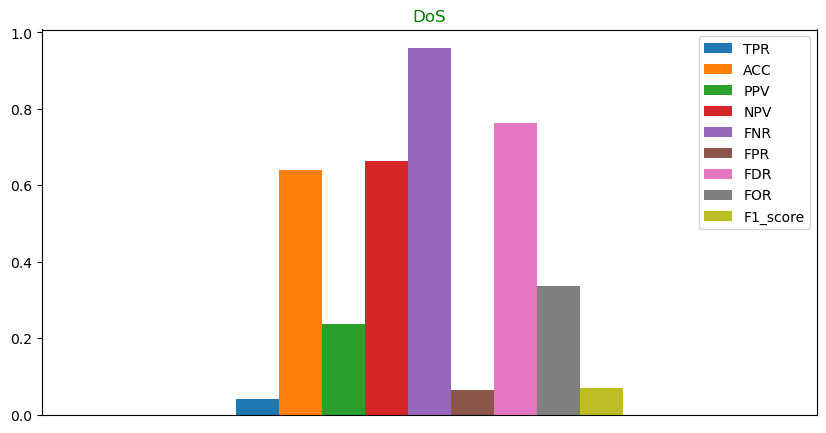

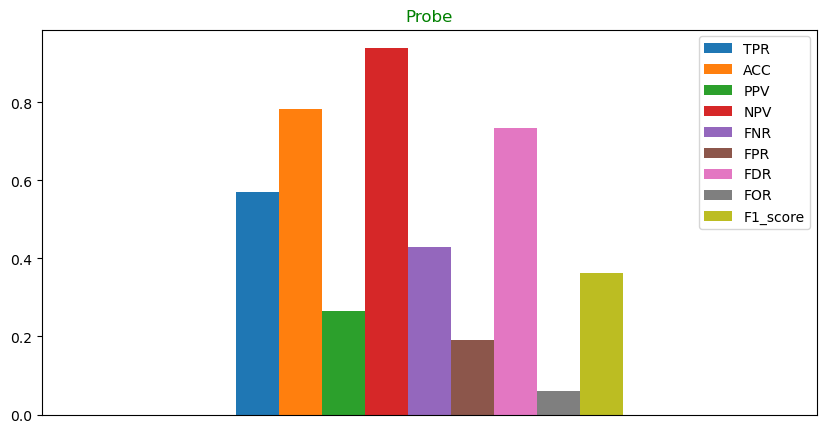

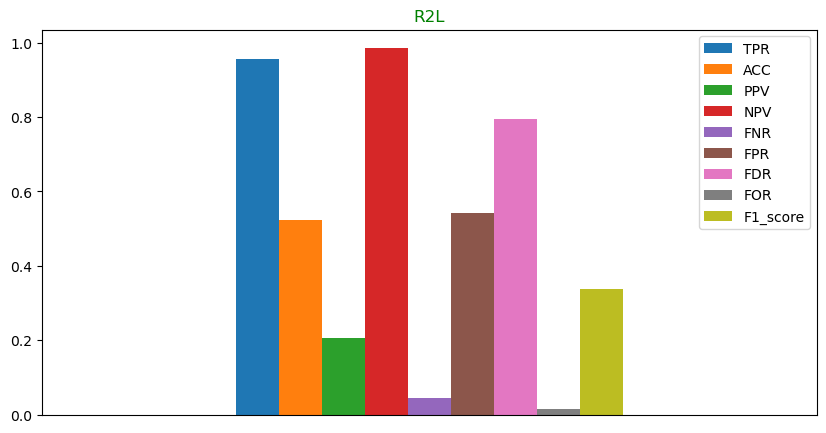

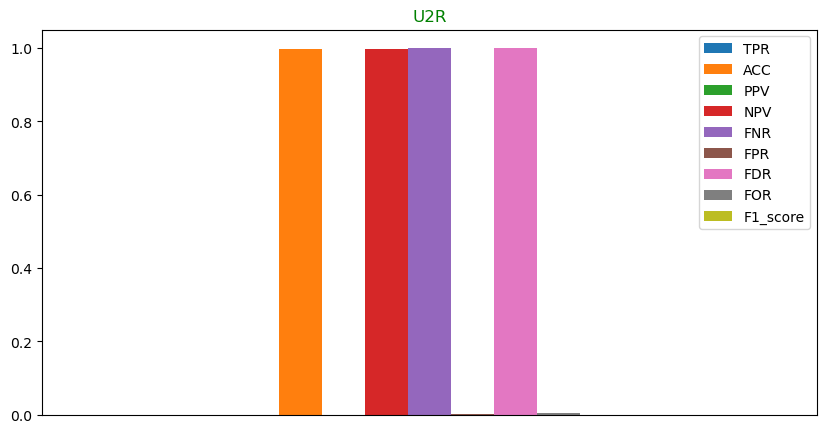

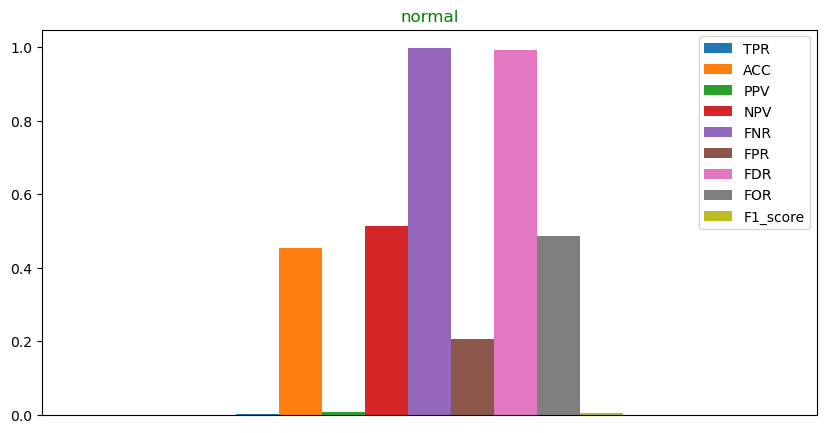

In [145]:
normal = {}
DoS = {}
Probe = {}
R2L = {}
U2R = {}

list_label = [normal, DoS, Probe, R2L, U2R]
sum_matrix = sum(sum(cm))
for c in range(len(list_label)):
    # True positive - số record mô hình dự đoán là attack giống như trong test dataset, dương tính đúng, dương tính thực
    tp = cm[c,c]
    # False positive - số record mô hình dự đoán là attack mà trong test dataset là normal, dương tính sai, dương tính giả
    fp = sum(cm[:,c]) - cm[c,c]
    # False negative - số record mô hình dự đoán là normal mà trong test dataset là attack, âm tính sai, âm tính giả
    fn = sum(cm[c,:]) - cm[c,c]
    # True negative - số record mô hình dự đoán là normal giống như trong test dataset, âm tính đúng, âm tính thật
    tn = sum_matrix - tp - fp - fn
    # Recall - True positive rate - độ nhạy - tỷ lệ dương tính thực
    list_label[c]['TPR'] = tp/(tp+fn)
    # Accuracy - độ chính xác
    list_label[c]['ACC'] = (tp+tn)/(tp+fp+fn+tn)
    # Precision - Positive Predictive Value - tỷ lệ dương tính đoán đúng
    list_label[c]['PPV'] = tp/(tp+fp)
    # Negative Predictive Value - tỷ lệ âm tính đoán đúng
    list_label[c]['NPV'] = tn/(tn+fn)
    # Miss Rate - False Negative Rate- tỷ lệ dương tính giả
    list_label[c]['FNR'] = 1 - list_label[c]['TPR']
    # Fall-out - False Positive Rate - Tỷ lệ âm tính giả 
    list_label[c]['FPR'] = fp/(fp+tn)
    # False Discovery Rate - tỷ lệ đoán dương tính sai
    list_label[c]['FDR'] = 1 - list_label[c]['PPV']
    # False Omission Rate - tỷ lệ đoán âm tính sai
    list_label[c]['FOR'] = 1 - list_label[c]['NPV']
    # F1 score - điểm F1 - điểm trung bình hài hòa giữa Precision và Recall
    list_label[c]['F1_score'] = (2*list_label[c]['PPV']*list_label[c]['TPR'])/(list_label[c]['PPV'] + list_label[c]['TPR'])
list_tt = ['normal', 'DoS', 'Probe', 'R2L', 'U2R']
for c in range(len(list_label)):

  normal = [list_label[c]]
  df = pd.DataFrame(normal)
  print(df)
  df.plot(kind='bar')
  plt.rcParams['figure.figsize'] = [10, 5]
  plt.rcParams['figure.dpi'] = 100
  plt.title(label=list_tt[c], color="green")
  plt.xlabel('') 
  plt.xticks([])
  plt.figure(1)
  plt.plot()

So với Hidden Markov Model (HMM) khi áp dụng Confusion Matrix, Covolutional Neural Network có độ chính xác (Accuracy) cao hơn

In [148]:
avg_acc = 0
for item in list_label:
    avg_acc+=item["ACC"]
avg_acc/=5
print("Average of Accuracy:",avg_acc)

Average of Accuracy: 0.679151880766501


# END: CONFUSION MATRIX